In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from scipy import stats
from astropy.stats import LombScargle
from astropy.time import Time
from gatspy.periodic import LombScargleMultiband, LombScargleMultibandFast, LombScargle, LombScargleFast, SuperSmoother, SuperSmootherMultiband

In [2]:
train_ts = pd.read_csv("../data/input/training_set.csv")
display(train_ts.head())

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


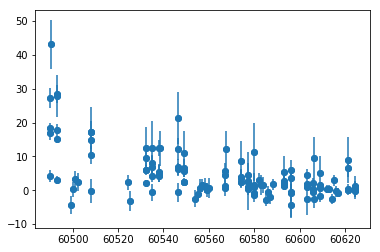

In [71]:
def get_divided_point(obj_data, thres_dist=100):
    obj_data = obj_data.sort_values('mjd', ascending=True)
    diff_mjd = obj_data.groupby('object_id')[['mjd']].diff()
    points = obj_data[diff_mjd > thres_dist]["mjd"].dropna().values
    points = np.concatenate([points, np.array([obj_data["mjd"].max()])])
    points = np.concatenate([np.array([obj_data["mjd"].min()]), points])
    
    result = []
    for i in range(len(points) - 1):
        result.append((points[i], points[i+1]))

    return result

def get_maxpoint(obj_data, thres_dict=100):
    points = get_divided_point(obj_data, thres_dict)

    max_result = []
    for point in points:
        max_result.append(obj_data.query('mjd >= @point[0] & mjd < @point[1]')["flux"].max())

    max_point = points[np.argmax(max_result)]
    return obj_data.query('mjd >= @max_point[0] & mjd < @max_point[1]')


sample = train_ts.query('object_id == 3041')
maxpoint = get_maxpoint(sample)

t = maxpoint["mjd"]
y = maxpoint["flux"]
y_err = maxpoint["flux_err"]
plt.scatter(t, y)
plt.errorbar(t, y, y_err, fmt="o")
plt.show()

In [41]:
thres_dist=100
sample = sample.sort_values('mjd', ascending=True)
diff_mjd = sample.groupby('object_id')[['mjd']].diff()
sup = sample[diff_mjd > thres_dist]["mjd"].dropna().values
sup = np.concatenate([sup, np.array([sample["mjd"].max()])])
sup = np.concatenate([np.array([sample["mjd"].min()]), sup])
sup

array([59750.4229, 60118.4163, 60490.2647, 60624.2132])

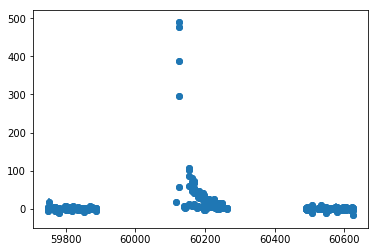

In [29]:
sample = train_ts.query('object_id == 2922')
t = sample["mjd"]
y = sample["flux"]
y_err = sample["flux_err"]
plt.scatter(t, y)
plt.errorbar(t, y, y_err, fmt="o")
plt.show()

In [8]:
model = SuperSmootherMultiband(fit_period=True)
model.optimizer.period_range = (0.1, int((sample['mjd'].max() - sample['mjd'].min()) / 2))
model.fit(sample["mjd"], sample["flux"], sample["flux_err"], sample["passband"])
model.best_period

Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 4.4e+02
 - Computing periods at 43681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


2.9877247580030066

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


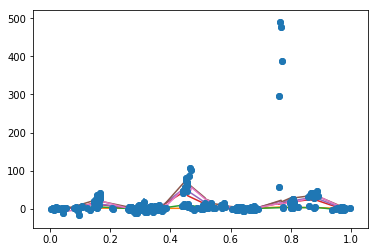

In [9]:
sample["phase"] = (sample["mjd"] / model.best_period) % 1
plt.scatter(sample["phase"], sample["flux"])
plt.errorbar(sample["phase"], sample["flux"], sample["flux_err"], fmt="o")

for i in [0,1,2,3,4,5]:
    pred = model.predict(np.linspace(0, model.best_period, 1000), i)
    plt.plot(np.linspace(0, 1, 1000), pred)
plt.show()

- 単一バンドで

In [6]:
model = SuperSmootherFast(fit_period=True)
model.optimizer.period_range = (0.1, int((sample['mjd'].max() - sample['mjd'].min()) / 2))
model.fit(sample["mjd"], sample["flux"], sample["flux_err"])
model.best_period

NameError: name 'SuperSmootherFast' is not defined

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


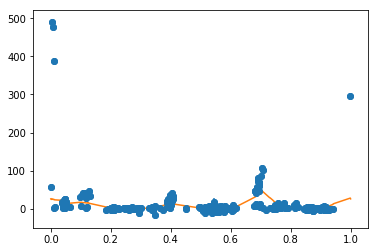

In [5]:
sample["phase"] = (sample["mjd"] / model.best_period) % 1
plt.scatter(sample["phase"], sample["flux"])
plt.errorbar(sample["phase"], sample["flux"], sample["flux_err"], fmt="o")

pred = model.predict(np.linspace(0, model.best_period, 1000))
plt.plot(np.linspace(0, 1, 1000), pred)
plt.show()